In [28]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import scipy.stats as stats
import seaborn as sns

In [2]:
path_archivo = "../input_data/KG.csv"
datos_full = pd.read_csv(path_archivo, delimiter = ",")

In [3]:
datos_full.head()

,K,G,rho,dx,dy,dz,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,shape
0,0.3,0.300000,0.2,0.1,0.1,0.1,6.846532,8.279029,8.279029,8.607635,8.607635,9.277155,9.277155,10.018620,10.188246,10.188246,cylinder
1,0.3,1.057143,0.2,0.1,0.1,0.1,12.049711,12.049711,12.852182,13.398173,14.267764,15.790196,15.968844,15.968844,16.066732,16.066732,cylinder
2,0.3,1.814286,0.2,0.1,0.1,0.1,13.056281,13.056281,13.708609,15.070374,16.836928,17.460062,18.984130,18.984130,20.396466,20.396466,cylinder
3,0.3,2.571429,0.2,0.1,0.1,0.1,13.531380,13.531380,13.847906,15.443661,18.665271,20.044593,20.686383,20.686383,22.354199,22.354199,cylinder
4,0.3,3.328571,0.2,0.1,0.1,0.1,13.815095,13.815095,13.931538,15.660428,19.674186,21.948089,21.948089,22.805466,23.808203,23.808203,cylinder


In [4]:
targets = ["K", "G"]
eig_pattern = r"^(w\d+|eig\d+|eig_\d+|\(omega\^2\)_\d+)$"
eig_columns = list(filter(lambda x: re.match(eig_pattern, x), datos_full.keys()))
non_eig_columns = ["rho"] #list(filter(lambda x: not re.match(eig_pattern, x) and x not in targets, datos_full.keys()))

In [5]:
def normalizar(dataSet, features, parametros = [], modo = "media-desv"):
    for feature in features:
        if (modo == "min-max") and (not sum(dataSet[feature]) == 0):
            param1 = min(dataSet[feature]) if len(parametros) == 0 else parametros[feature]["minimo"]
            param2 = max(dataSet[feature]) if len(parametros) == 0 else parametros[feature]["maximo"]
            dataSet[feature] = (dataSet[feature] - param1)/(param2 - param1)
        elif (modo == "max") and (not sum(dataSet[feature]) == 0):
            param2 = max(dataSet[feature]) if len(parametros) == 0 else parametros[feature]["maximo"]
            dataSet[feature] = (dataSet[feature])/(param2)
        else:
            media = np.mean(dataSet[feature]) if len(parametros) == 0 else parametros[feature]["media"]
            desviacion = np.std(dataSet[feature]) if len(parametros) == 0 else parametros[feature]["desviacion"]
            if desviacion != 0:
                dataSet[feature] = (dataSet[feature] - media)/desviacion
            #fin if 
        #fin if 
#fin función

In [6]:
N_eig = 10
features_eig = eig_columns[:N_eig]
#features.remove("shape")
"""
Si intentas normalizar con min-max la cosa se pone peluda. Y obviamente si intentamos estandarizar hay que decirle adiosito al logaritmo. 
"""
normalizar(datos_full, features = features_eig + ["rho"], modo = "max")

In [7]:
datos_full.head()

,K,G,rho,dx,dy,dz,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,shape
0,0.3,0.300000,0.02,0.1,0.1,0.1,0.145362,0.175776,0.175776,0.182752,0.182752,0.173976,0.173976,0.176647,0.179637,0.177602,cylinder
1,0.3,1.057143,0.02,0.1,0.1,0.1,0.255833,0.255833,0.272870,0.284462,0.302925,0.296117,0.299467,0.281560,0.283286,0.280076,cylinder
2,0.3,1.814286,0.02,0.1,0.1,0.1,0.277203,0.277203,0.291053,0.319966,0.357472,0.327432,0.356013,0.334725,0.359627,0.355553,cylinder
3,0.3,2.571429,0.02,0.1,0.1,0.1,0.287290,0.287290,0.294011,0.327891,0.396290,0.375900,0.387936,0.364739,0.394145,0.389680,cylinder
4,0.3,3.328571,0.02,0.1,0.1,0.1,0.293314,0.293314,0.295786,0.332493,0.417711,0.411597,0.411597,0.402102,0.419782,0.415026,cylinder


In [8]:
price, fitted_lambda = stats.boxcox(datos_full['K'])
print('Box-Cox for elastic moduli', round(fitted_lambda, 2))

if "rho" in datos_full.keys():
    price, fitted_lambda = stats.boxcox(datos_full['rho'])
    print('Box-Cox for density', round(fitted_lambda, 2))
#fin if 

price, fitted_lambda = stats.boxcox(datos_full['w0'])
print('Box-Cox for frequencies', round(fitted_lambda, 2))

Box-Cox for elastic moduli 0.7
Box-Cox for density 0.67
Box-Cox for frequencies -0.18


In [9]:
def execute_ols(d_frame, features_op, features_nop, target, operation = "", intercept = True):
    if type(operation) == str:
        features_mod = list(map(lambda x: operation + "(" + x +")", features_op)) 
    else:
        features_mod = list(map(lambda x, y: y + "(" + x +")", features_op, operation))
    #fin if 
    sum_desglosado = " + ".join(features_mod + features_nop)
    str_intc = " -1" if intercept else ""
    formula_full = target + " ~ " + sum_desglosado + str_intc
    print(formula_full)
    model = smf.ols(formula = formula_full, data = d_frame).fit()
    return model
#fin función

In [10]:
features_mas = ["rho"] if "rho" in datos_full.keys() else []
modelo1 = execute_ols(datos_full, features_eig, features_mas, targets[0], operation = "np.log")

K ~ np.log(w0) + np.log(w1) + np.log(w2) + np.log(w3) + np.log(w4) + np.log(w5) + np.log(w6) + np.log(w7) + np.log(w8) + np.log(w9) + rho -1


In [11]:
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      K   R-squared (uncentered):                   0.714
Model:                            OLS   Adj. R-squared (uncentered):              0.714
Method:                 Least Squares   F-statistic:                          3.719e+04
Date:                Mon, 30 Sep 2024   Prob (F-statistic):                        0.00
Time:                        08:53:07   Log-Likelihood:                     -3.3150e+05
No. Observations:              163840   AIC:                                  6.630e+05
Df Residuals:                  163829   BIC:                                  6.631e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
np.log(w0)    -0.3110      0.027    -11.527      0.000      -0.364      -0.258
np.log(w1)    -2.4004      0.029    -83.127      0.000      -2.457      -2.344
np.log(w2)    -0.1380      0.039     -3.494      0.000      -0.215      -0.061
np.log(w3)     4.6601      0.055     84.340      0.000       4.552       4.768
np.log(w4)    -0.8035      0.058    -13.795      0.000      -0.918      -0.689
np.log(w5)     0.8692      0.063     13.836      0.000       0.746       0.992
np.log(w6)    -1.2311      0.083    -14.890      0.000      -1.393      -1.069
np.log(w7)     0.4361      0.085      5.109      0.000       0.269       0.603
np.log(w8)    -0.5823      0.095     -6.117      0.000      -0.769      -0.396
np.log(w9)    -0.9315      0.073    -12.743      0.000      -1.075      -0.788
rho           -0.7416      0.020    -37.026      0.000      -0.781      -0.702
==============================================================================
Omnibus:                    21459.482   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5410.708
Skew:                           0.014   Prob(JB):                         0.00
Kurtosis:                       2.110   Cond. No.                         506.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
fun_rho = lambda x: x**(-(1/2))
if "rho" in datos_full.keys():
    features_m2 = features_eig + ["rho"]
    operation_m2 = ["np.log"]*len(features_eig) + ["np.sqrt"]
else:
    features_m2 = features_eig; operation_m2 = "np.log"
#fin if 
modelo2 = execute_ols(datos_full, features_m2, [], "np.sqrt(" + targets[0] + ")", operation = operation_m2)
modelo2.summary()

np.sqrt(K) ~ np.log(w0) + np.log(w1) + np.log(w2) + np.log(w3) + np.log(w4) + np.log(w5) + np.log(w6) + np.log(w7) + np.log(w8) + np.log(w9) + np.sqrt(rho) -1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             np.sqrt(K)   R-squared (uncentered):                   0.847
Model:                            OLS   Adj. R-squared (uncentered):              0.847
Method:                 Least Squares   F-statistic:                          8.230e+04
Date:                Mon, 30 Sep 2024   Prob (F-statistic):                        0.00
Time:                        08:53:07   Log-Likelihood:                     -1.6744e+05
No. Observations:              163840   AIC:                                  3.349e+05
Df Residuals:                  163829   BIC:                                  3.350e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
np.log(w0)      -0.2381      0.010    -24.033      0.000      -0.257      -0.219
np.log(w1)      -1.0915      0.011   -102.937      0.000      -1.112      -1.071
np.log(w2)      -0.2733      0.014    -18.851      0.000      -0.302      -0.245
np.log(w3)       2.1363      0.020    105.518      0.000       2.097       2.176
np.log(w4)       0.0838      0.021      3.925      0.000       0.042       0.126
np.log(w5)       0.1048      0.023      4.520      0.000       0.059       0.150
np.log(w6)       0.0005      0.030      0.015      0.988      -0.059       0.060
np.log(w7)      -0.3018      0.031     -9.625      0.000      -0.363      -0.240
np.log(w8)      -0.1601      0.035     -4.577      0.000      -0.229      -0.092
np.log(w9)      -0.4859      0.027    -18.083      0.000      -0.539      -0.433
np.sqrt(rho)    -0.2902      0.011    -27.106      0.000      -0.311      -0.269
==============================================================================
Omnibus:                     3537.307   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3229.046
Skew:                          -0.296   Prob(JB):                         0.00
Kurtosis:                       2.651   Cond. No.                         507.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

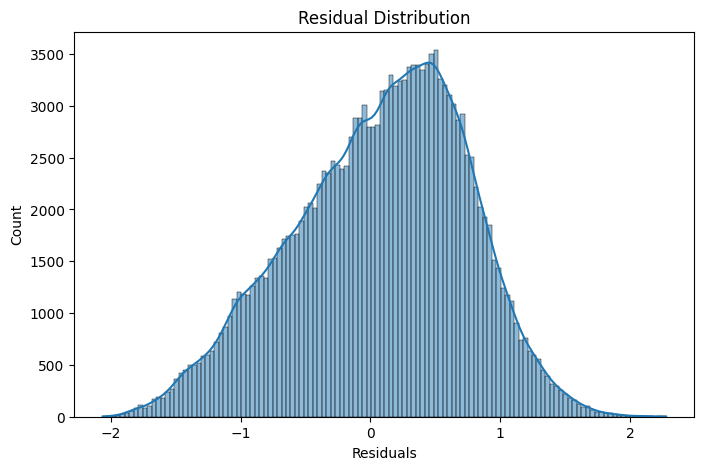

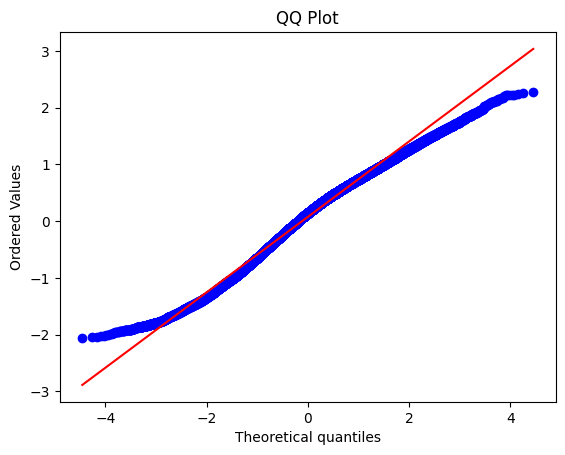

In [21]:
def residuals_plots(model):
    residuals = model.resid
    
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')
    plt.xlabel('Residuals')
    plt.show()
    
    stats.probplot(x=residuals, dist="norm", plot=plt)
    plt.title("QQ Plot")
    plt.show()
#fin función 

residuals_plots(modelo2)

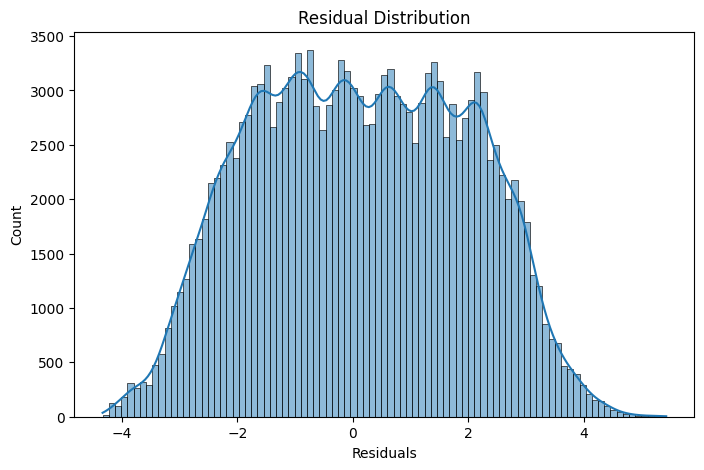

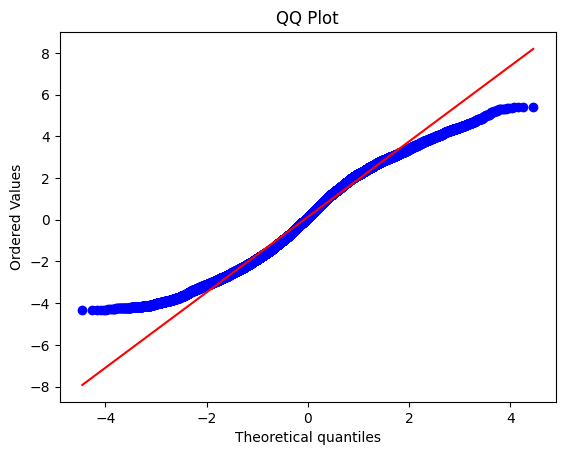

In [23]:
residuals_plots(modelo1)

In [31]:
def check_heteroscedasticity(model):
    residuals = model.resid
    exog = model.model.exog 
    exog_with_constant = sm.add_constant(exog, has_constant='add')
    bp_test = het_breuschpagan(residuals, exog_with_constant)
    labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    bp_results = dict(zip(labels, bp_test))
    
    print('Breusch-Pagan Test Results:')
    for key, value in bp_results.items():
        print(f'{key}: {value}')

# Example usage with smf.ols model
check_heteroscedasticity(modelo2)

Breusch-Pagan Test Results:
Lagrange multiplier statistic: 6200.70360549169
p-value: 0.0
f-value: 585.8304332132485
f p-value: 0.0
